In [1]:
from __future__ import annotations
import os, sys, json, warnings, requests
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from glob import glob

with open(os.getcwd().replace(r'\Analise', '') + '\\config.json') as config_file:
    config = json.load(config_file)
    sys.path.append(config['caminho_rede'])

from Arquivos.ColetaDados.ToolsColeta import MainParameters


column_len = 200

pl.Config.set_fmt_str_lengths(column_len)  # Ajuste o valor de acordo com a sua necessidade
pd.set_option('display.max_colwidth', column_len)  # Altere 200 conforme necessário

warnings.filterwarnings("ignore")
proj_dir = os.getcwd().replace(r'\Arquivos\Analise', '')


# Análise Exploratória dos Dados Sócio-Econômicos dos Municípios do ZEEC-ES 

## Censo 2022

### População

População:  ['id_municipio', 'id_municipio_nome', 'forma_declaracao_idade', 'sexo', 'idade', 'idade_anos', 'grupo_idade', 'populacao_residente']
Distribuição da população por grupo de idade


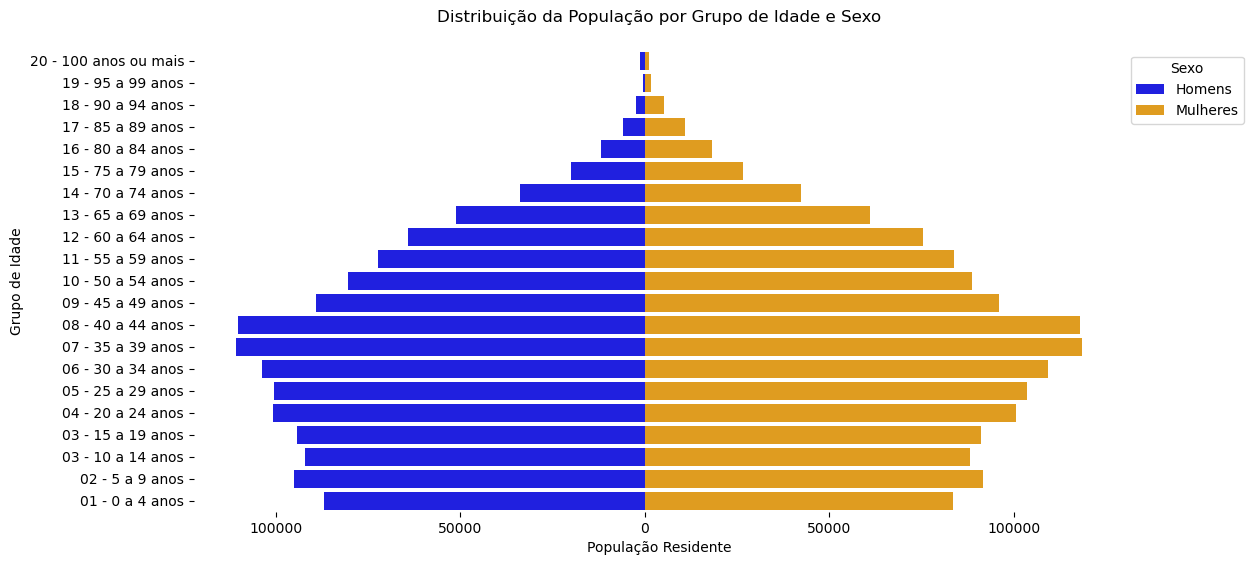

Ideia: colocar linha da pirâmide etária de 2010. (Jornal Nexo)


In [16]:

def create_age_distribution(female_df, male_df, year):
    male_color = 'blue'
    female_color = 'orange'
    df_f = female_df.loc[::-1]
    df_m = male_df.loc[::-1]
    ax = sns.barplot(y=df_m["grupo_idade"], x=df_m['populacao_residente'], orient="h", color="blue", label="Homens")
    sns.barplot(y=df_f["grupo_idade"], x=df_f['populacao_residente'], orient="h", color="orange", label="Mulheres")
    
    # Inverter o eixo y para a ordem correta
    plt.gca().invert_yaxis()

    # Remover as linhas de margem e os eixos
    sns.despine(left=True, bottom=True)
    # plt.axis('off')

    # Personalizar os rótulos do eixo x para que apareçam como positivos
    x_labels = ax.get_xticks()

    ax.set_xticklabels([int(abs(x)) for x in x_labels])

    # Adicionar legenda
    plt.legend(title="Sexo", loc="upper right")
    
    # Adicionar título e rótulos
    plt.title('Distribuição da População por Grupo de Idade e Sexo', pad=20)
    plt.xlabel('População Residente')
    plt.ylabel('Grupo de Idade')
    # plt.legend()
    
    return ax


df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Pop', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('População: ', df.columns)

df = df.with_columns(
    pl.when(pl.col('sexo') == 'Homens')
      .then(pl.col('populacao_residente') * -1)
      .otherwise(pl.col('populacao_residente'))
      .alias('populacao_residente')
)

df = df.with_columns((pl.col('grupo_idade').replace('0 a 4 anos', '01 - 0 a 4 anos')
                                           .replace('5 a 9 anos', '02 - 5 a 9 anos')
                                           .replace('10 a 14 anos', '03 - 10 a 14 anos')
                                           .replace('15 a 19 anos', '03 - 15 a 19 anos')
                                           .replace('20 a 24 anos', '04 - 20 a 24 anos')
                                           .replace('25 a 29 anos', '05 - 25 a 29 anos')
                                           .replace('30 a 34 anos', '06 - 30 a 34 anos')
                                           .replace('35 a 39 anos', '07 - 35 a 39 anos')
                                           .replace('40 a 44 anos', '08 - 40 a 44 anos')
                                           .replace('45 a 49 anos', '09 - 45 a 49 anos')
                                           .replace('50 a 54 anos', '10 - 50 a 54 anos')
                                           .replace('55 a 59 anos', '11 - 55 a 59 anos')
                                           .replace('60 a 64 anos', '12 - 60 a 64 anos')
                                           .replace('65 a 69 anos', '13 - 65 a 69 anos')
                                           .replace('70 a 74 anos', '14 - 70 a 74 anos')
                                           .replace('75 a 79 anos', '15 - 75 a 79 anos')
                                           .replace('80 a 84 anos', '16 - 80 a 84 anos')
                                           .replace('85 a 89 anos', '17 - 85 a 89 anos')
                                           .replace('90 a 94 anos', '18 - 90 a 94 anos')
                                           .replace('95 a 99 anos', '19 - 95 a 99 anos')
                                           .replace('100 anos ou mais', '20 - 100 anos ou mais'))
)


print('Distribuição da população por grupo de idade')

# Continuar usando o dataframe df_grouped que já agrupa por grupo de idade e sexo
df_grouped = df.group_by(['grupo_idade', 'sexo']) \
          .agg([pl.sum("populacao_residente").alias("populacao_residente")]) \
          .sort(['grupo_idade', 'sexo'], descending=True)


df_fem = df_grouped.filter(pl.col('sexo').str.contains("Mulheres")).to_pandas()
df_men = df_grouped.filter(pl.col('sexo').str.contains("Homens")).to_pandas()


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
ax = create_age_distribution(df_fem, df_men, year=2022)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Sexo')
plt.show()


print('Ideia: colocar linha da pirâmide etária de 2010. (Jornal Nexo)')

### Alfabetização

In [3]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Alfabetizados', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Alfabetização: ', df.columns)

print('Média Aritmética de Alfabetização nos Municípios')
display(df.with_columns(pl.col("taxa_alfabetizacao").replace('-', None).cast(pl.Float64))
          .drop_nulls('taxa_alfabetizacao')\
          .group_by(['cor_raca', 'grupo_idade']) \
          .agg([pl.mean("taxa_alfabetizacao").alias("taxa_alfabetizacao")]) \
          .sort(['taxa_alfabetizacao'], descending=False) \
          .head(10))

Alfabetização:  ['id_municipio', 'id_municipio_nome', 'cor_raca', 'sexo', 'grupo_idade', 'taxa_alfabetizacao']
Média Aritmética de Alfabetização nos Municípios


cor_raca,grupo_idade,taxa_alfabetizacao
str,str,f64
"""Preta""","""80 anos ou mais""",50.042381
"""Preta""","""75 anos ou mais""",52.694419
"""Parda""","""80 anos ou mais""",59.451364
"""Preta""","""65 anos ou mais""",63.146818
"""Parda""","""75 anos ou mais""",63.669091
"""Indígena""","""75 anos ou mais""",65.556667
"""Indígena""","""80 anos ou mais""",66.294583
"""Indígena""","""65 anos ou mais""",69.283243
"""Parda""","""65 anos ou mais""",73.34


### Abastecimento de Água

In [4]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Agua', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Abastecimento de Água: ', df.columns)

print('Domicílios por grupo de abastecimento')
display(df.group_by(['tipo_ligacao_rede_geral']) \
          .agg([pl.sum("domicilios").alias("tipo_ligacao")]) \
          .sort("tipo_ligacao", descending=True) \
          .with_columns(pl.col("tipo_ligacao").cast(pl.Int32)) \
          .head(10))

print('Total de domicílios: ', df['domicilios'].sum())

display('"Possui ligação à rede": ', df.filter(pl.col('tipo_ligacao_rede_geral').str.contains("Possui ligação à rede"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())
display('"Possui ligação à rede como forma principal": ', df.filter(pl.col('tipo_ligacao_rede_geral').str.contains("Possui ligação à rede geral e a utiliza como forma principal"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())

display('"NÃO possui ligação à rede": ', df.filter(pl.col('tipo_ligacao_rede_geral').str.contains("Não possui"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())


Abastecimento de Água:  ['ano', 'id_municipio', 'id_municipio_nome', 'tipo_ligacao_rede_geral', 'domicilios']
Domicílios por grupo de abastecimento


tipo_ligacao_rede_geral,tipo_ligacao
str,i32
"""Possui ligação à rede geral e a utiliza como forma principal""",934018
"""Não possui ligação com a rede geral""",64343
"""Não possui ligação com a rede geral - Poço profundo ou artesiano""",38196
"""Possui ligação à rede geral, mas utiliza principalmente outra forma""",17839
"""Não possui ligação com a rede geral - Poço raso, freático ou cacimba""",16834
"""Possui ligação à rede geral, mas utiliza principalmente outra forma - Poço profundo ou artesiano""",14700
"""Não possui ligação com a rede geral - Fonte, nascente ou mina""",6247
"""Possui ligação à rede geral, mas utiliza principalmente outra forma - Poço raso, freático ou cacimba""",1889
"""Não possui ligação com a rede geral - Outra""",1344


Total de domicílios:  1098382


'"Possui ligação à rede": '

domicilios
f64
0.88284


'"Possui ligação à rede como forma principal": '

domicilios
f64
0.850358


'"NÃO possui ligação à rede": '

domicilios
f64
0.11716


### Saneamento

In [5]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Esgoto', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Saneamento: ', df.columns)

print('Domicílios por grupo de saneamento')
display(df.group_by(['tipo_esgotamento_sanitario']) \
          .agg([pl.sum("domicilios").alias("tipo_ligacao")]) \
          .sort("tipo_ligacao", descending=True) \
          .with_columns(pl.col("tipo_ligacao").cast(pl.Int32)) \
          .head(10))

print('Total de domicílios: ', df['domicilios'].sum())

display('"Possui ligação à rede geral": ', df.filter(pl.col('tipo_esgotamento_sanitario').str.contains("Rede geral"))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())
display('"Possui sistema ligado à rede": ', df.filter(pl.col('tipo_esgotamento_sanitario').str.contains_any(["Rede geral, rede pluvial", 
                                                                                                                           'Fossa séptica ou fossa filtro ligada à rede']))
                                 .select(pl.col('domicilios'))
                                 .sum()/df['domicilios'].sum())

display('"NÃO possui sistema ligado à rede": ', 1+(df.filter(pl.col('tipo_esgotamento_sanitario').str.contains_any(["Rede geral, rede pluvial", 
                                                                                                                                   'Fossa séptica ou fossa filtro ligada à rede']))
                                 .select(pl.col('domicilios'))
                                 .sum()*-1 )/df['domicilios'].sum())

Saneamento:  ['ano', 'id_municipio', 'id_municipio_nome', 'tipo_esgotamento_sanitario', 'domicilios']
Domicílios por grupo de saneamento


tipo_esgotamento_sanitario,tipo_ligacao
str,i32
"""Rede geral, rede pluvial ou fossa ligada à rede""",826351
"""Rede geral ou pluvial""",813041
"""Fossa rudimentar ou buraco""",92124
"""Fossa séptica ou fossa filtro não ligada à rede""",67236
"""Vala""",17667
"""Fossa séptica ou fossa filtro ligada à rede""",13310
"""Rio, lago, córrego ou mar""",9553
"""Outra forma""",2809
"""Não tinham banheiro nem sanitário""",460


Total de domicílios:  1842551


'"Possui ligação à rede geral": '

domicilios
f64
0.88974


'"Possui sistema ligado à rede": '

domicilios
f64
0.455706


'"NÃO possui sistema ligado à rede": '

domicilios
f64
0.544294


## Acesso à Internet e Conectividade

### Densidade de Acessos

Acesso à Internet:  ['sigla_uf', 'sigla_uf_nome', 'ano', 'mes', 'id_municipio', 'id_municipio_nome', 'densidade']
Estatística Descritiva da Densidade de Acessos à Internet (agregado 2021/01-2024/02), % domicilios com acesso à internet


statistic,value
str,f64
"""count""",722.0
"""null_count""",0.0
"""mean""",18.710582
"""std""",8.437458
"""min""",2.81
"""25%""",12.59
"""50%""",17.47
"""75%""",24.3
"""max""",77.99


Ranking de Densidade de Acessos em 2024/02


densidade,id_municipio_nome,ano,mes
f64,str,i64,i64
39.36,"""Vitória""",2024,2
31.63,"""Vila Velha""",2024,2
30.23,"""Guarapari""",2024,2
28.04,"""Cachoeiro de Itapemirim""",2024,2
28.0,"""Piúma""",2024,2
27.32,"""Cariacica""",2024,2
25.23,"""Linhares""",2024,2
24.47,"""Marataízes""",2024,2
22.91,"""Serra""",2024,2


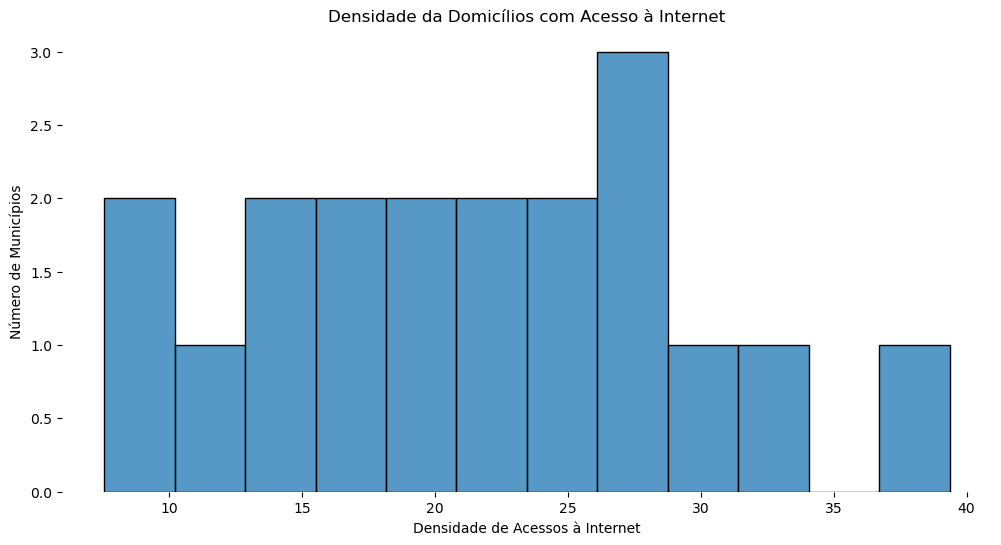

In [6]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Densidade Internet', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Acesso à Internet: ', df.columns)


print('Estatística Descritiva da Densidade de Acessos à Internet (agregado 2021/01-2024/02), % domicilios com acesso à internet')
display(df['densidade'].round(2).describe())


print('Ranking de Densidade de Acessos em 2024/02')
display(df.filter((pl.col("ano") == 2024) & (pl.col('mes') == 2)) \
           .select(["densidade", "id_municipio_nome", 'ano', 'mes']) \
           .with_columns(pl.col("densidade").round(2)) \
           .sort("densidade", descending=True) \
           .head(10))


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
sns.histplot(df.filter((pl.col("ano") == 2024) & (pl.col('mes') == 2))['densidade'], bins=12)

# Adicionando os rótulos personalizados
plt.ylabel('Número de Municípios')
plt.xlabel('Densidade de Acessos à Internet')
plt.title('Densidade da Domicílios com Acesso à Internet')
sns.despine(left=True, bottom=True)


plt.show()

### Empresas e Fornecedores

In [7]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Banda Larga', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Fornecedores de acesso à internet: ', df.columns)

print('Pontos de acessos em 2024')
df_acessos = df.filter(pl.col('ano') == 2024)\
          .group_by(['transmissao', 'velocidade']) \
          .agg([pl.sum("acessos").alias("acessos")]) \
          .with_columns((pl.col("acessos") / pl.col("acessos").sum()).alias('acessos %').round(4)) \
          .sort("acessos", descending=True)

display(df_acessos.head(10))

print('Concentração de fornecedores em 2024')
df_supp = df.filter(pl.col('ano') == 2024)\
          .group_by(['empresa', 'porte_empresa']) \
          .agg([pl.sum("acessos").alias("acessos")]) \
          .with_columns((pl.col("acessos") / pl.col("acessos").sum()).alias('market share').round(4)) \
          .sort("acessos", descending=True)

display(df_supp.head(10))
print('soma top 10: ', df_supp.head(10).sum())

print('Total de fornecedores: ', df_supp['empresa'].count())


Fornecedores de acesso à internet:  ['mes', 'ano', 'porte_empresa', 'transmissao', 'id_municipio', 'id_municipio_nome', 'acessos', 'velocidade', 'empresa', 'cnpj', 'produto', 'tecnologia', 'sigla_uf', 'sigla_uf_nome']
Pontos de acessos em 2024


transmissao,velocidade,acessos,acessos %
str,str,i64,f64
"""Fibra""","""> 34Mbps""",1042423,0.7268
"""Cabo Coaxial""","""> 34Mbps""",250762,0.1748
"""Fibra""","""12Mbps a 34Mbps""",37193,0.0259
"""Radio""","""512kbps a 2Mbps""",35089,0.0245
"""Fibra""","""2Mbps a 12Mbps""",10792,0.0075
"""Cabo Metalico""","""12Mbps a 34Mbps""",10010,0.007
"""Cabo Metalico""","""2Mbps a 12Mbps""",9172,0.0064
"""Fibra""","""512kbps a 2Mbps""",7893,0.0055
"""Radio""","""2Mbps a 12Mbps""",7848,0.0055


Concentração de fornecedores em 2024


empresa,porte_empresa,acessos,market share
str,str,i64,f64
"""VIVO""","""Grande Porte""",282822,0.1972
"""CLARO""","""Grande Porte""",272607,0.1901
"""OI""","""Grande Porte""",250509,0.1747
"""GIGA MAIS FIBRA""","""Pequeno Porte""",154401,0.1077
"""R7 TELECOMUNICACOES LTDA""","""Pequeno Porte""",111524,0.0778
"""KORE BRASIL LTDA""","""Pequeno Porte""",34752,0.0242
"""Megalink Servicos Ltda""","""Pequeno Porte""",34160,0.0238
"""REAL LIFE COMERCIO E SERVICOS LTDA-ME""","""Pequeno Porte""",20506,0.0143
"""Brasil Radiowave Ltda""","""Pequeno Porte""",13551,0.0094


soma top 10:  shape: (1, 4)
┌─────────┬───────────────┬─────────┬──────────────┐
│ empresa ┆ porte_empresa ┆ acessos ┆ market share │
│ ---     ┆ ---           ┆ ---     ┆ ---          │
│ str     ┆ str           ┆ i64     ┆ f64          │
╞═════════╪═══════════════╪═════════╪══════════════╡
│ null    ┆ null          ┆ 1186548 ┆ 0.8274       │
└─────────┴───────────────┴─────────┴──────────────┘
Total de fornecedores:  237


## CAGED

CAGED:  ['ano', 'mes', 'sigla_uf', 'sigla_uf_nome', 'id_municipio', 'id_municipio_nome', 'cnae_2_secao', 'cnae_2_subclasse', 'saldo_movimentacao', 'categoria', 'grau_instrucao', 'idade', 'horas_contratuais', 'raca_cor', 'sexo', 'tipo_empregador', 'tipo_estabelecimento', 'tipo_movimentacao', 'tipo_deficiencia', 'indicador_trabalho_intermitente', 'indicador_trabalho_parcial', 'salario_mensal', 'tamanho_estabelecimento_janeiro', 'indicador_aprendiz', 'origem_informacao', 'indicador_fora_prazo']
Estatística Descritiva de Horas Semanais de Trabalho e Salário Mensal (2021/01 - 2024-01)


statistic,idade,horas_contratuais,salario_mensal
str,f64,f64,f64
"""count""",2.252148e6,2.251231e6,2.251118e6
"""null_count""",122.0,1039.0,1152.0
"""mean""",32.575487,42.003108,1913.407382
"""std""",10.980623,6.50628,15812.227172
"""min""",14.0,0.0,0.0
"""25%""",24.0,44.0,1285.07
"""50%""",31.0,44.0,1416.5
"""75%""",40.0,44.0,1866.18
"""max""",93.0,60.0,1.3341412e7


Contratações (2021/01 - 2024-01)


id_municipio_nome,total_movimentacao
str,i32
"""Serra""",271989
"""Vitória""",236912
"""Vila Velha""",183983
"""Cariacica""",99362
"""Linhares""",87097
"""Aracruz""",76608
"""Cachoeiro de Itapemirim""",60161
"""São Mateus""",43909
"""Guarapari""",35140


Demissões/Saídas (2021/01 - 2024-01)


id_municipio_nome,total_movimentacao
str,i32
"""Serra""",-247145
"""Vitória""",-213303
"""Vila Velha""",-165388
"""Cariacica""",-89661
"""Linhares""",-79585
"""Aracruz""",-68968
"""Cachoeiro de Itapemirim""",-54378
"""São Mateus""",-37834
"""Guarapari""",-31052


Distribuição de Salários em 2024/01 (trimmed em 1%)


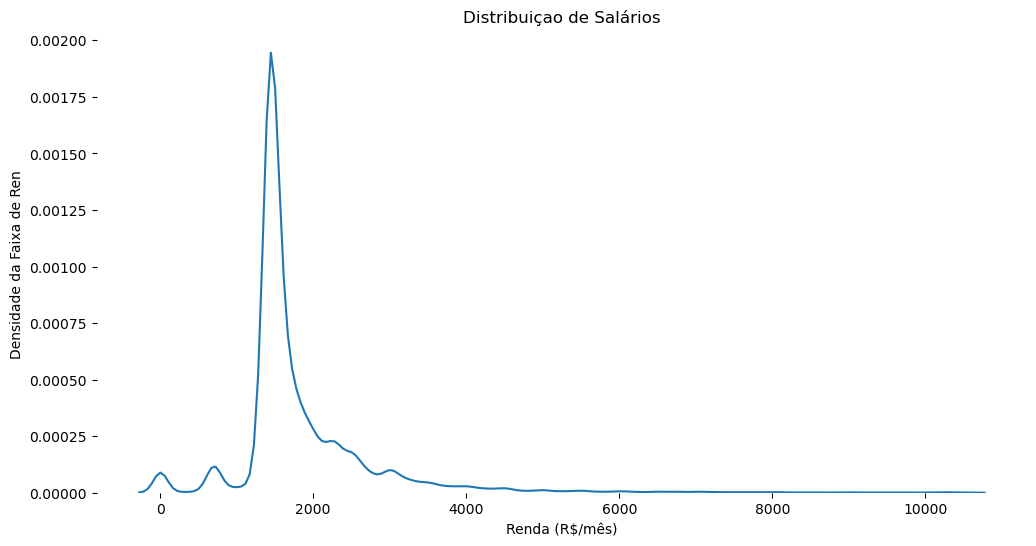

In [8]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'CAGED', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('CAGED: ', df.columns)


print('Estatística Descritiva de Horas Semanais de Trabalho e Salário Mensal (2021/01 - 2024-01)')
display(df[['idade', 'horas_contratuais', 'salario_mensal']].describe())

print('Contratações (2021/01 - 2024-01)')
display(df.filter(pl.col('saldo_movimentacao') == 1)\
          .group_by("id_municipio_nome") \
          .agg([pl.sum("saldo_movimentacao").alias("total_movimentacao")]) \
          .sort("total_movimentacao", descending=True) \
          .with_columns(pl.col("total_movimentacao").cast(pl.Int32)) \
          .head(10))

print('Demissões/Saídas (2021/01 - 2024-01)')
display(df.filter(pl.col('saldo_movimentacao') == -1)\
          .group_by("id_municipio_nome") \
          .agg([pl.sum("saldo_movimentacao").alias("total_movimentacao")]) \
          .sort("total_movimentacao", descending=False) \
          .with_columns(pl.col("total_movimentacao").cast(pl.Int32)) \
          .head(10))

# Filtrar apenas os valores do ano 2024
df_2024 = df.filter(pl.col("ano") == 2024)

# Calcular os quantis de 1% e 99% (extremos a serem removidos)
q_low = df_2024['salario_mensal'].quantile(0.005)
q_high = df_2024['salario_mensal'].quantile(0.995)

# Filtrar os dados para remover os valores fora do intervalo dos 2% extremos
df_filtered = df_2024.filter(
    (pl.col("salario_mensal") >= q_low) & (pl.col("salario_mensal") <= q_high))


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
print('Distribuição de Salários em 2024/01 (trimmed em 1%)')
sns.kdeplot(df_filtered['salario_mensal'])
plt.ylabel('Densidade da Faixa de Ren ')
plt.xlabel('Renda (R$/mês)')
plt.title('Distribuiçao de Salários')
sns.despine(left=True, bottom=True)

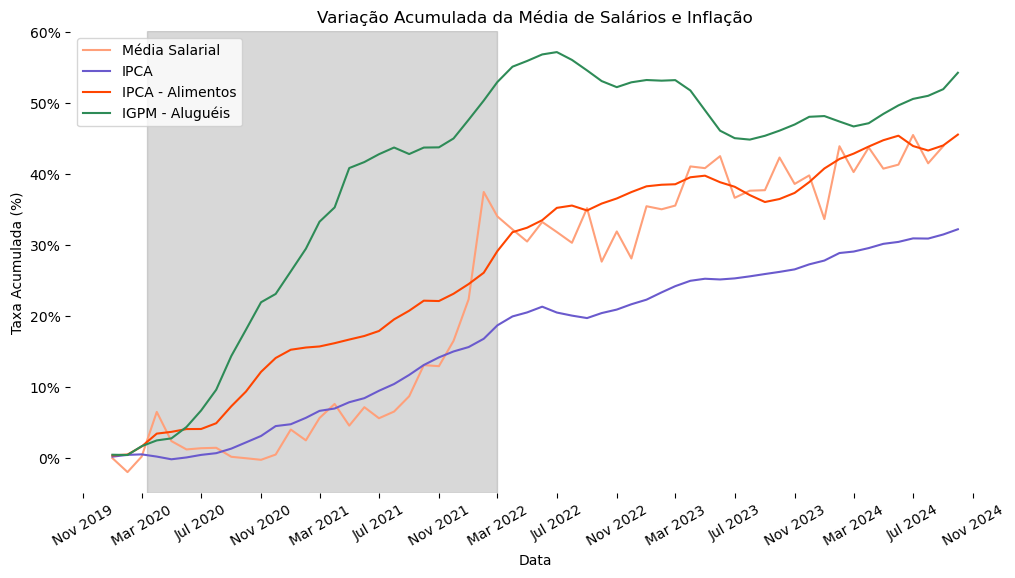

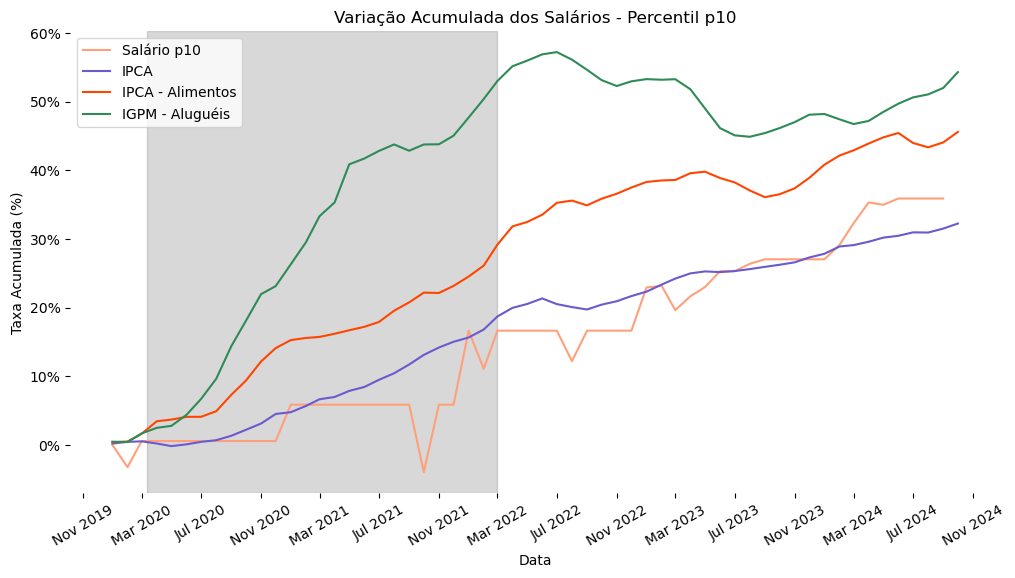

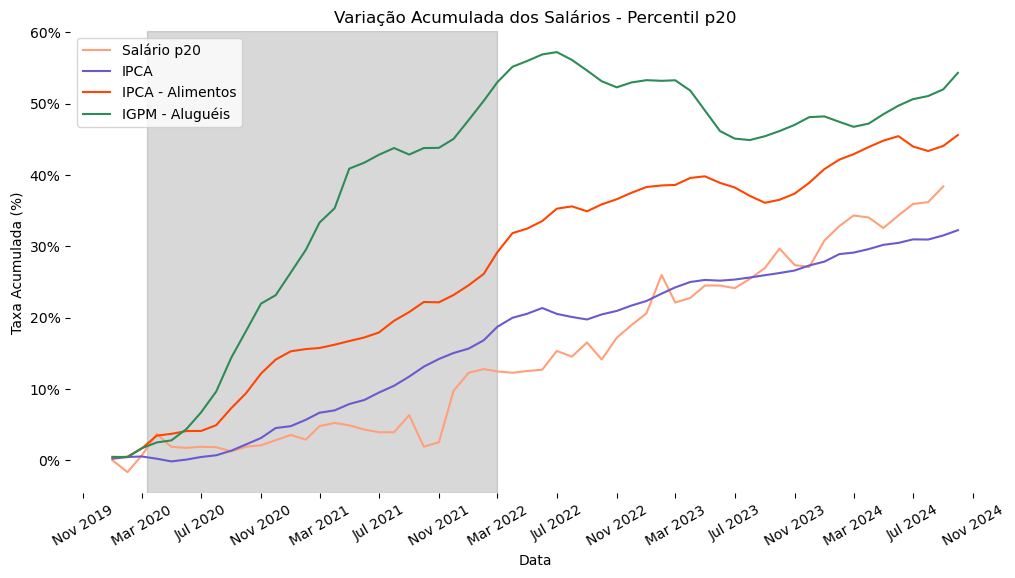

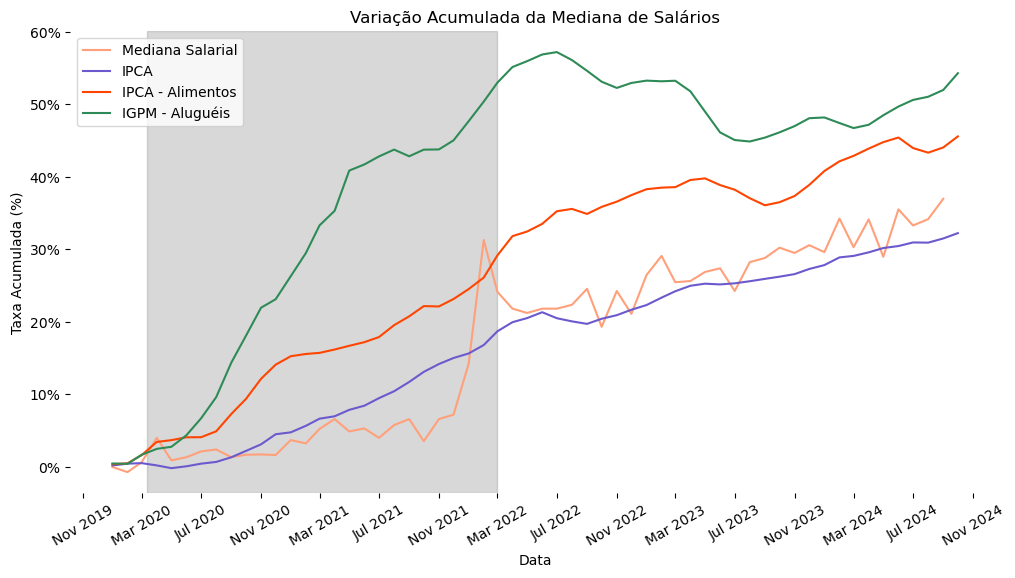

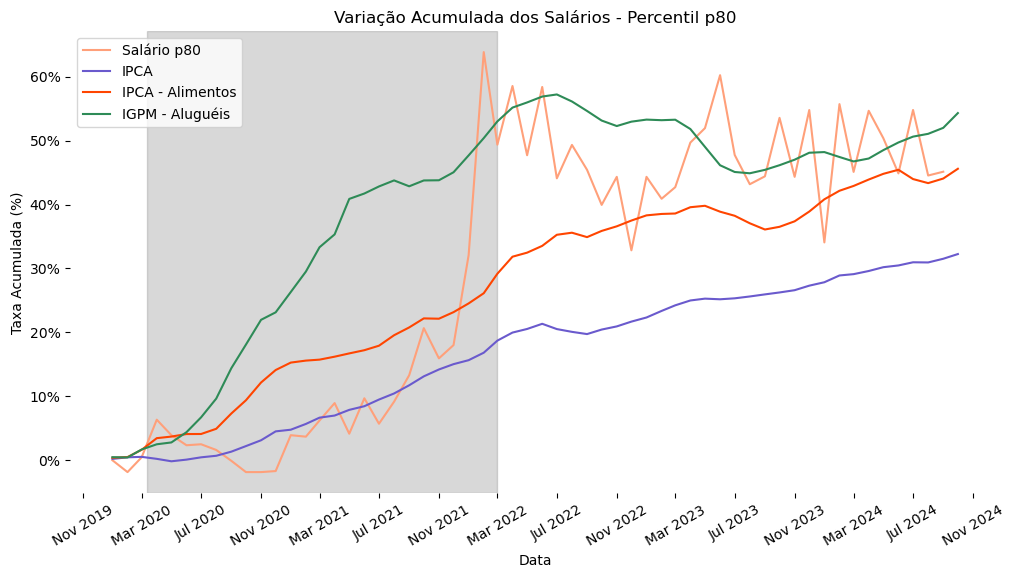

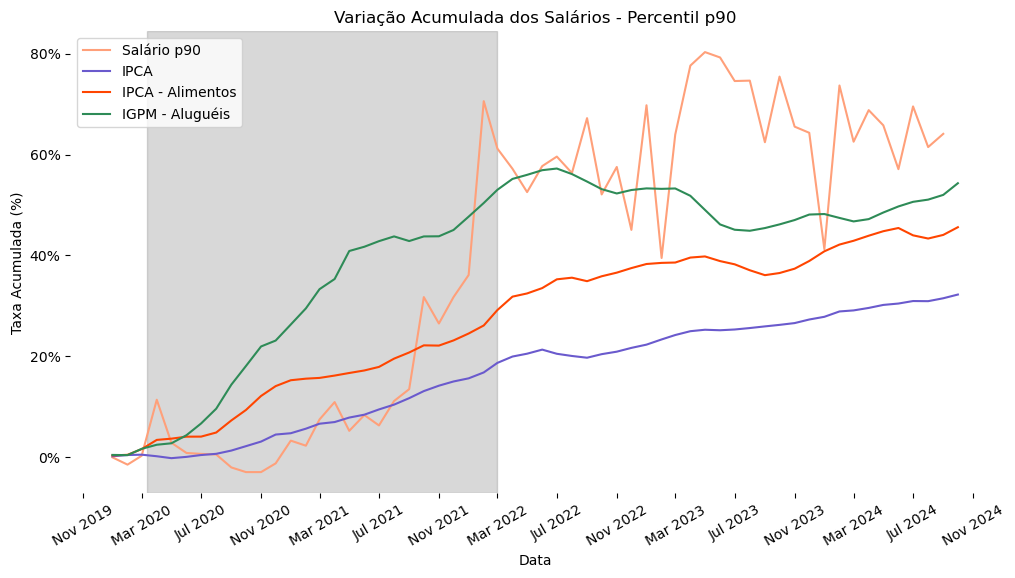

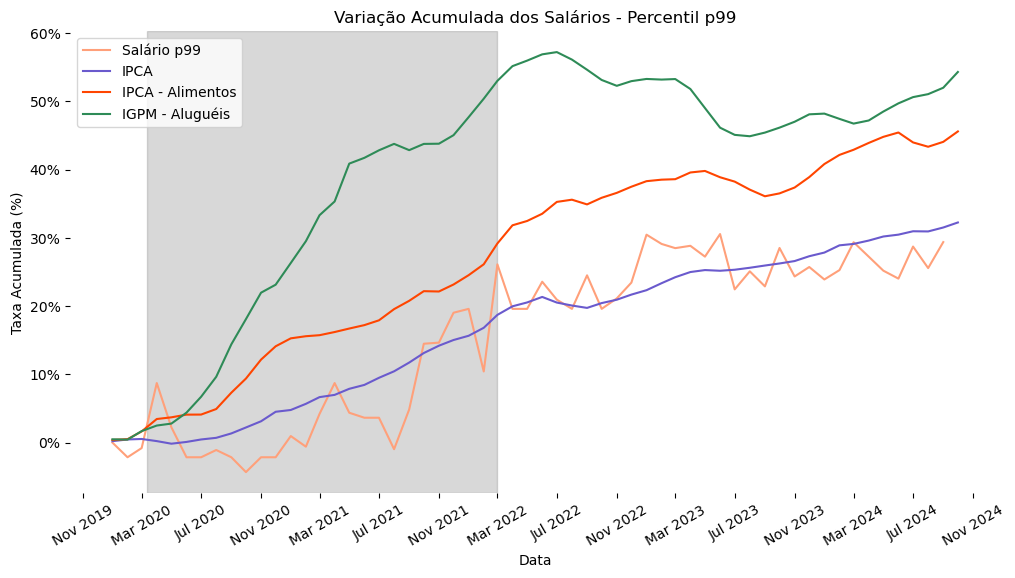

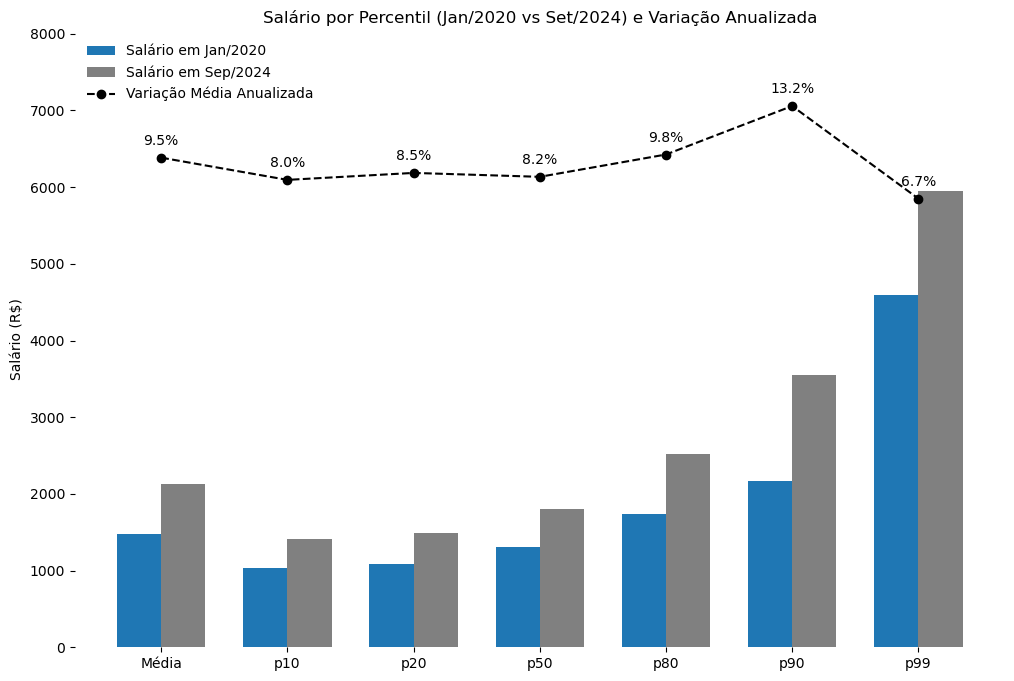


Tabela de Salários e Variação Anualizada:


,Percentil,Salário Jan/2020,Salário Sep/2024,Variação Anualizada (%)
0,Média,1476.953625,2126.395347,9.539130
1,p10,1039.000000,1412.000000,7.970419
2,p20,1079.550000,1494.000000,8.461838
3,p50,1313.250000,1799.000000,8.185969
4,p80,1732.100000,2513.910000,9.760023
5,p90,2163.200000,3549.640000,13.180578
6,p99,4598.790000,5950.000000,6.651839


,data,valor,acumulado
0,2000-01-01,0.0124,0.012400
1,2000-02-01,0.0035,0.015943
2,2000-03-01,0.0015,0.017467
3,2000-04-01,0.0023,0.019807
4,2000-05-01,0.0031,0.022969
...,...,...,...
293,2024-06-01,0.0081,5.382150
294,2024-07-01,0.0061,5.421082
295,2024-08-01,0.0029,5.439703
296,2024-09-01,0.0062,5.479629


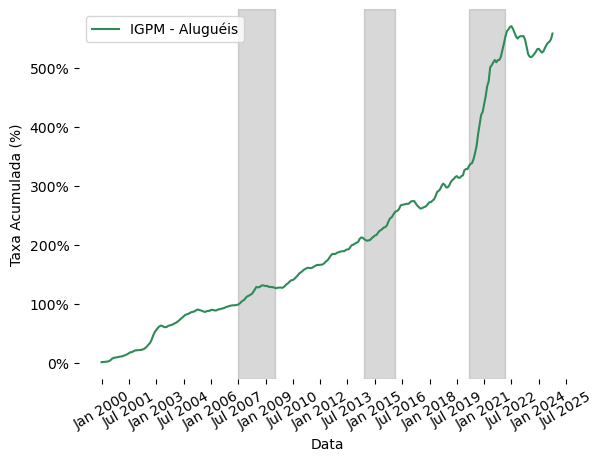

In [ ]:
# Inflação e Salários (dados nacionais, por enquanto)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta

ipca = 433
igpm_rent = 189
ipca_food = 1635

def calcular_variacao_acumulada_percentil_salario(data: pd.DataFrame, tipo_movimentacao='admissão', percentis=['p10', 'p20', 'p50', 'p80', 'p90', 'p99']):
    # Filtra o DataFrame pelo tipo de movimentação
    data['tipo_movimentacao'] = data['tipo_movimentacao'].str.strip().str.lower()
    data_filtrada = data[data['tipo_movimentacao'] == tipo_movimentacao.strip().lower()]

    # Combina ano e mês em uma única coluna de data e ordena
    data_filtrada['data'] = pd.to_datetime(data_filtrada['ano'].astype(str) + '-' + data_filtrada['mes'].astype(str) + '-01')
    data_filtrada = data_filtrada.sort_values('data')

    # Calcula a variação acumulada para cada percentil
    variacao_acumulada = pd.DataFrame({'data': data_filtrada['data']})
    for p in percentis:
        variacao_acumulada[f'var_{p}'] = data_filtrada[p].pct_change().fillna(0)
        variacao_acumulada[f'var_{p}'] = (1 + variacao_acumulada[f'var_{p}']).cumprod() - 1

    # Adiciona a média salarial ao DataFrame, se a coluna existir
    if 'media_agregada' in data.columns:
        variacao_acumulada[f'media_agregada'] = data_filtrada['media_agregada'].pct_change().fillna(0)
        variacao_acumulada[f'var_ - Média'] = (1 + variacao_acumulada[f'media_agregada']).cumprod() - 1

    else:
        print("Coluna 'salario_mensal' não encontrada. Média salarial não será calculada.")

    return variacao_acumulada

def get_series_data(series_code, anos: int = 4):
    # Definir a data inicial como janeiro de 2021 e a data final como hoje
    data_inicial = f'01/01/{2024-anos}'
    data_final = datetime.today().strftime('%d/%m/%Y')
    url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.{series_code}/dados?formato=json&dataInicial={data_inicial}&dataFinal={data_final}"

    # Fazer a requisição para a API
    response = requests.get(url)
    
    if response.status_code == 200:  # Verifica se a requisição foi bem-sucedida
        # Converter a resposta JSON para DataFrame
        series_data = pd.DataFrame(response.json())
        
        # Transformar as colunas 'data' e 'valor' para os tipos corretos
        series_data['data'] = pd.to_datetime(series_data['data'], format='%d/%m/%Y')
        series_data['valor'] = series_data['valor'].astype(float)/100
        
        # Calcular a média geométrica para calcular o retorno médio anual
        series_data['acumulado'] = (series_data['valor'] + 1).cumprod() - 1

        return series_data
    else:
        print(f"Erro na requisição: {response.status_code} - {response.text}")
        return None

# Carregar os dados do percentil

percentil_data = pd.read_parquet((os.path.join(proj_dir, 'Dados', 'Caged Es', fr'caged_ES.parquet')))

# Calcular a variação acumulada de salários
variacao_acumulada_salario_admissao = calcular_variacao_acumulada_percentil_salario(percentil_data, tipo_movimentacao='admissão')

# Obter as séries dos índices de inflação
ipca_series = get_series_data(series_code=ipca)
food_series = get_series_data(series_code=ipca_food)
igpm_series = get_series_data(series_code=igpm_rent)

# Filtrar os dados dos índices para começar a partir de janeiro de 2021
data_inicio = pd.to_datetime('2020-01-01')
ipca_series = ipca_series[ipca_series['data'] >= data_inicio]
food_series = food_series[food_series['data'] >= data_inicio]
igpm_series = igpm_series[igpm_series['data'] >= data_inicio]


colors = {
    'media': '#FFA07A',  # Light Salmon
    'ipca': '#6A5ACD',   # Slate Blue
    'food': '#FF4500',   # Orange Red
    'igpm': '#2E8B57'    # Sea Green
}

# Gerar gráficos um a um
for p in [' - Média', 'p10', 'p20', 'p50', 'p80', 'p90', 'p99']:
    plt.figure(figsize=(12, 6))
    if p == ' - Média':
        # Para a média
        sns.lineplot(data=variacao_acumulada_salario_admissao, x='data', y='var_ - Média', 
                     label='Média Salarial', color=colors['media'])
        plt.title('Variação Acumulada da Média de Salários e Inflação')
    
    elif p == 'p50':
        # Para a média
        sns.lineplot(data=variacao_acumulada_salario_admissao, x='data', y=f'var_{p.strip()}', 
                     label='Mediana Salarial', color=colors['media'])
        plt.title('Variação Acumulada da Mediana de Salários')
    else:
        sns.lineplot(data=variacao_acumulada_salario_admissao, x='data', y=f'var_{p.strip()}',
                     label=f'Salário {p}', color=colors['media'])
        plt.title(f'Variação Acumulada dos Salários - Percentil {p}')
    
    # Adiciona os índices de inflação ao gráfico
    plt.plot(ipca_series['data'], ipca_series['acumulado'], label='IPCA', color=colors['ipca'])
    plt.plot(food_series['data'], food_series['acumulado'], label='IPCA - Alimentos', color=colors['food'])
    plt.plot(igpm_series['data'], igpm_series['acumulado'], label='IGPM - Aluguéis', color=colors['igpm'])

    plt.ylabel('Taxa Acumulada (%)')
    plt.xlabel('Data')
    
    plt.xticks(rotation=30)
    plt.legend(loc='upper left')
    plt.xticks(rotation=30)
    sns.despine(left=True, bottom=True)

    # Destacar o período da pandemia
    ax = plt.gca()
    pandemic_start = datetime(2020, 3, 11)
    pandemic_end = datetime(2022, 3, 1)
    ax.axvspan(pandemic_start, pandemic_end, color='grey', alpha=0.3, label='Período da Pandemia')

    # Configuração do eixo X para exibir rótulos mensais
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Define intervalo mensal
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato: Mês (abreviado) e Ano

    # Transformar eixo Y em porcentagem
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Supondo que os valores estão em formato decimal (ex., 0.02 = 2%)
    plt.show()


def plot_salario_percentil_e_variacao(data: pd.DataFrame, percentis=['media_agregada', 'p10', 'p20', 'p50', 'p80', 'p90', 'p99']):
    percentis_labels = ['Média' if p == 'media_agregada' else p for p in percentis]

    # Filtrar apenas os dados de janeiro de 2020 e do mês mais recente
    data['data'] = pd.to_datetime(data['ano'].astype(str) + '-' + data['mes'].astype(str) + '-01')
    data_2020_jan = data[data['data'] == '2020-01-01']
    data_recente = data[data['data'] == data['data'].max()]

    # Extrair salários dos percentis em janeiro de 2020 e no período mais recente
    salario_percentil_2020 = data_2020_jan[percentis].iloc[0]
    salario_percentil_recente = data_recente[percentis].iloc[0]

    # Calcular variação média geométrica anualizada
    anos = (data_recente['data'].dt.year.iloc[0] - data_2020_jan['data'].dt.year.iloc[0])
    variacao_anualizada = ((salario_percentil_recente / salario_percentil_2020) ** (1 / anos) - 1) * 100

    # Plotar os dados
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Gráfico de barras para salários em janeiro de 2020 e no mês mais recente
    x = range(len(percentis))
    width = 0.35
    ax1.bar([p - width / 2 for p in x], salario_percentil_2020, width=width, label='Salário em Jan/2020')
    ax1.bar([p + width / 2 for p in x], salario_percentil_recente, width=width, 
            label=f'Salário em {data_recente["data"].max().strftime("%b/%Y")}',
            color = 'grey')
    ax1.set_xticks(x)
    ax1.set_xticklabels(percentis_labels)
    ax1.set_ylabel('Salário (R$)')
    ax1.set_ylim(0, max(salario_percentil_recente) * 1.35)
   
    
    # Gráfico de linha para a variação média geométrica anualizada
    ax2 = ax1.twinx()
    ax2.plot(x, variacao_anualizada, color='black', marker='o', linestyle='--', label='Variação Média Anualizada')
    ax2.spines['right'].set_position(('outward', 60))  # Ajusta a posição para evitar sobreposição da legenda

    # ax2.set_ylabel('Variação Anualizada (%)')
    ax2.set_ylim(-25, max(variacao_anualizada) * 1.4)
    ax2.set_yticks([])

    # Adiciona rótulos aos pontos da linha de variação anualizada
    for i, v in enumerate(variacao_anualizada):
        ax2.text(i, v + 0.9, f"{v:.1f}%", ha='center', color='black', fontsize=10)
  
    # Consolida a legenda dos dois gráficos em uma só
    ax1.legend(loc='upper left', frameon=False)
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.93), frameon=False)
    sns.despine(left=True, bottom=True)

    plt.title('Salário por Percentil (Jan/2020 vs Set/2024) e Variação Anualizada')
    plt.show()

    # Criar e exibir tabela com dados de janeiro de 2020 e o mais recente
    tabela_variacao = pd.DataFrame({
        'Percentil': percentis_labels,
        'Salário Jan/2020': salario_percentil_2020.values,
        f'Salário {data_recente["data"].max().strftime("%b/%Y")}': salario_percentil_recente.values,
        'Variação Anualizada (%)': variacao_anualizada.values
    })
    
    print("\nTabela de Salários e Variação Anualizada:")
    display(tabela_variacao)

plot_salario_percentil_e_variacao(percentil_data)


igpm = get_series_data(series_code=igpm_rent, anos= 24)

display(igpm)


plt.plot(igpm['data'], igpm['acumulado'], label='IGPM - Aluguéis', color=colors['igpm'])

plt.ylabel('Taxa Acumulada (%)')
plt.xlabel('Data')

plt.xticks(rotation=30)
plt.legend(loc='upper left')
plt.xticks(rotation=30)
sns.despine(left=True, bottom=True)

ax = plt.gca()
# Crise do Subprime
subprime_start = datetime(2007, 7, 1)      # Crise começa a se intensificar com problemas nos mercados
subprime_end = datetime(2009, 6, 30)       # Final da recessão nos EUA e estabilização dos mercados
ax.axvspan(subprime_start, subprime_end, color='grey', alpha=0.3, label='Crise do Subprime')

# Queda no Preço do Petróleo
oil_crash_start = datetime(2014, 6, 1)     # Início da queda acentuada nos preços do petróleo
oil_crash_end = datetime(2016, 1, 31)      # Estabilização dos preços em um novo patamar baixo
ax.axvspan(oil_crash_start, oil_crash_end, color='grey', alpha=0.3, label='Queda no Preço do Petróleo')

# Pandemia de COVID-19
pandemic_start = datetime(2020, 3, 11)     # Declaração de pandemia pela OMS
pandemic_end = datetime(2022, 3, 1)        # Relaxamento das restrições em muitos países
ax.axvspan(pandemic_start, pandemic_end, color='grey', alpha=0.3, label='Período da Pandemia')

# Configuração do eixo X para exibir rótulos mensais
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=18))  # Define intervalo mensal
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formato: Mês (abreviado) e Ano

# Transformar eixo Y em porcentagem
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Supondo que os valores estão em formato decimal (ex., 0.02 = 2%)
plt.show()




## RAIS

### Estabelecimentos

RAIS:  ['ano', 'sigla_uf', 'sigla_uf_nome', 'id_municipio', 'id_municipio_nome', 'quantidade_vinculos_ativos', 'quantidade_vinculos_clt', 'quantidade_vinculos_estatutarios', 'natureza_estabelecimento', 'tamanho_estabelecimento', 'tipo_estabelecimento', 'indicador_cei_vinculado', 'indicador_pat', 'indicador_simples', 'indicador_atividade_ano', 'cnae_1', 'cnae_1_descricao', 'cnae_1_descricao_grupo', 'cnae_1_descricao_divisao', 'cnae_1_descricao_secao', 'cnae_2', 'cnae_2_descricao_subclasse', 'cnae_2_descricao_classe', 'cnae_2_descricao_grupo', 'cnae_2_descricao_divisao', 'cnae_2_descricao_secao', 'subsetor_ibge', 'subatividade_ibge']
Estatística Descritiva de Quantidade de Vínculos Ativos e CLTistas (2022)


statistic,quantidade_vinculos_ativos,quantidade_vinculos_clt
str,f64,f64
"""count""",233584.0,233584.0
"""null_count""",0.0,0.0
"""mean""",6.156132,5.480345
"""std""",70.093124,36.674641
"""min""",0.0,0.0
"""25%""",0.0,0.0
"""50%""",1.0,1.0
"""75%""",3.0,3.0
"""max""",15423.0,5263.0


Distribuição de Vínculos Ativos


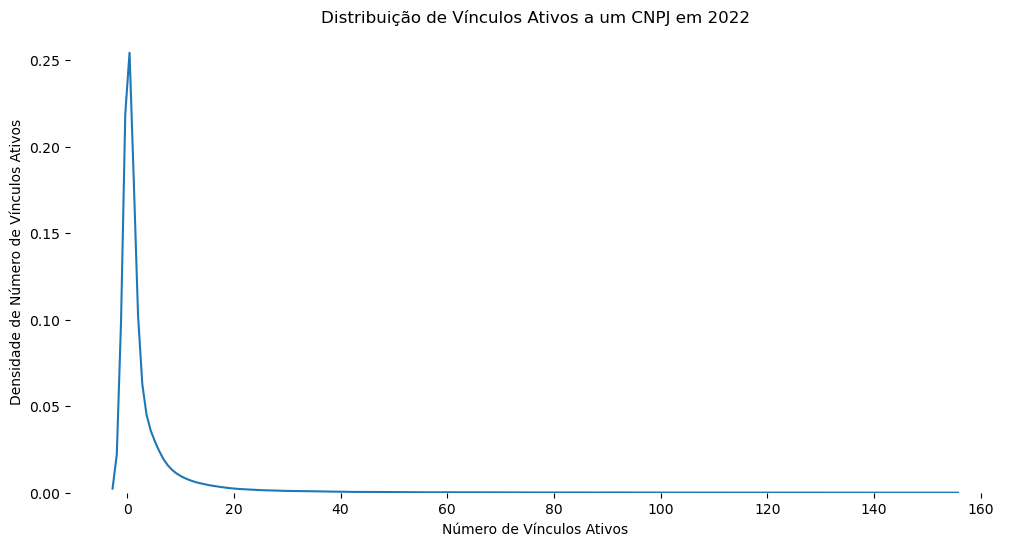

In [9]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'RAIS', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('RAIS: ', df.columns)

print('Estatística Descritiva de Quantidade de Vínculos Ativos e CLTistas (2022)')
display(df.filter(pl.col('ano') == 2022)[['quantidade_vinculos_ativos', 'quantidade_vinculos_clt']].describe())


# Filtrar apenas os valores do ano 2022
df_2022 = df.filter(pl.col("ano") == 2022)

# Calcular os quantis de 1% e 99% (extremos a serem removidos)
q_low = df_2022['quantidade_vinculos_ativos'].quantile(0.005)
q_high = df_2022['quantidade_vinculos_ativos'].quantile(0.995)

# Filtrar os dados para remover os valores fora do intervalo dos 2% extremos
df_filtered = df_2022.filter(
    (pl.col("quantidade_vinculos_ativos") >= q_low) & (pl.col("quantidade_vinculos_ativos") <= q_high))


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
print('Distribuição de Vínculos Ativos')
sns.kdeplot(df_filtered['quantidade_vinculos_ativos'])
plt.ylabel('Densidade de Número de Vínculos Ativos')
plt.xlabel('Número de Vínculos Ativos')
plt.title('Distribuição de Vínculos Ativos a um CNPJ em 2022')
sns.despine(left=True, bottom=True)

### Vínculos

In [1]:
# Ainda não construído

## CNPJs 

CNPJs:  ['data', 'cnpj', 'situacao_cadastral', 'data_situacao_cadastral', 'motivo_situacao_cadastral', 'data_inicio_atividade', 'cnae_fiscal_secundaria', 'sigla_uf', 'id_municipio_rf', 'bairro', 'cep', 'cnae_fiscal', 'id_municipio_nome']
10 Maiores CNAES em 2024/08


cnae_fiscal,num_cnpjs,nome
str,u32,str
"""4722902""",624,"""Peixaria"""
"""5590699""",503,"""Outros alojamentos não especificados anteriormente"""
"""5510801""",403,"""Hotéis"""
"""4763604""",194,"""Comércio varejista de artigos de caça, pesca e camping"""
"""7912100""",160,"""Operadores turísticos"""
"""0810006""",142,"""Extração de areia, cascalho ou pedregulho e beneficiamento associado"""
"""5232000""",109,"""Atividades de agenciamento marítimo"""
"""0810002""",98,"""Extração de granito e beneficiamento associado"""
"""0600001""",78,"""Extração de petróleo e gás natural"""


Número de Estabelecimentos em 2024


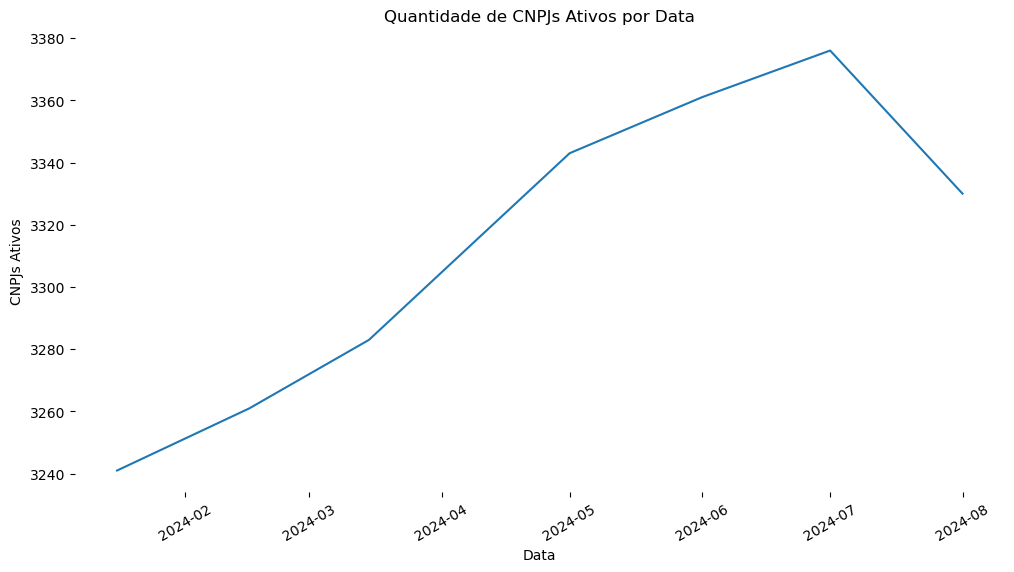

In [10]:
param = MainParameters()

def insert_cnpjs_link(ano:int, meses:list):
    df = pl.DataFrame()
    str_dtype = pl.String

    for mes in meses:
        file = os.path.join(r'C:\Users\galve\MyDrive\Carreira\ObservatorioES\Dados\Cnpj Estabelecimentos', f'cnpj_estabelecimentos_{ano}_{mes}.parquet')
        # Read each Parquet file with Polars
        cnpj_df = pl.read_parquet(file)

        # Rename columns as per your requirement
        cnpj_df = cnpj_df.rename({'uf': 'sigla_uf'})
        

        df = pl.concat([df, cnpj_df])

    df_mun = pl.read_csv(os.path.join(proj_dir, 'Dados', 'Cnpj Empresas', 'dict_municipios.csv'), 
                             encoding= 'latin1', 
                             schema={'':str_dtype,  'id_municipio_rf': str_dtype,	'id_municipio_nome': str_dtype,	
                                    'id_municipio': str_dtype, 'sigla_uf': str_dtype})
    df = df.join(df_mun, on='id_municipio_rf', how='left')

    # df = df.drop('cnpj_basico', 'cnpj_ordem', 'cnpj_dv', 'matriz_filial', 'id_municipio', 'sigla_uf_right',
    #              'tipo_logradouro', 'logradouro', 'numero', 'complemento', '')
    
    df = df[['data', 'cnpj', 'situacao_cadastral', 'data_situacao_cadastral', 'motivo_situacao_cadastral', 'data_inicio_atividade', 'cnae_fiscal_secundaria', 
             'sigla_uf', 'id_municipio_rf', 'bairro', 'cep', 'cnae_fiscal', 'id_municipio_nome']]
    #        .with_columns([pl.col("data").str.strptime(pl.Date, format="%Y-%m-%d").alias("data"),
    #                       pl.col("data_inicio_atividade").cast(pl.Date),
    #                       pl.col("data_situacao_cadastral").cast(pl.Date)            
    #                       ])
    df = df.filter((pl.col('id_municipio_rf').str.contains_any(list(param.cod_rf()))) & 
                    pl.col('cnae_fiscal').str.contains_any(param.cnae_analise()))


    return df



def insert_cnpjs_bd(anos: list, chunksize: int = 500000):

    df = pl.DataFrame()
    for ano in anos:
        file = os.path.join(proj_dir, 'Dados', 'Cnpj Estabelecimentos', f'cnpj_estabelecimentos_{ano}.parquet')
        # Read the Parquet file using Polars
        cnpj_df = pl.read_parquet(file)

        # Renomear ou excluir colunas conforme necessário
        cnpj_df = cnpj_df.drop(['cnae_fiscal_principal', 'uf', 'id_municipio_nome_right'])
        df = pl.concat([df, cnpj_df])
        df = df.filter((pl.col('id_municipio_rf').str.contains_any(list(param.cod_rf()))) & 
                        pl.col('cnae_fiscal').str.contains_any(param.cnae_analise()))

    return df

df_link = insert_cnpjs_link(2024, ['05', '06', '07', '08'])
df_bd = insert_cnpjs_bd([2024])
df = pl.concat([df_bd, df_link])
print('CNPJs: ', df.columns)

cnae_dict = {'cnae': 'nome',
            '4722902': 'Peixaria',
            "5590699":	'Outros alojamentos não especificados anteriormente',
            "5510801":	'Hotéis',
            "4763604":	'Comércio varejista de artigos de caça, pesca e camping',
            "7912100":	'Operadores turísticos',
            "0810006":	'Extração de areia, cascalho ou pedregulho e beneficiamento associado',
            "5232000":	'Atividades de agenciamento marítimo',
            "0810002":	'Extração de granito e beneficiamento associado',
            "0600001":	'Extração de petróleo e gás natural',
            "7420002": 'Atividades de produção de fotografias aéreas e submarinas'}
cnae = pl.DataFrame(cnae_dict)
cnae = cnae.transpose(include_header=True, column_names=['nome'])

print('10 Maiores CNAES em 2024/08')
display(df.filter((pl.col('situacao_cadastral').str.contains_any(['Ativa', '02']))
                  & (pl.col('data') >= pl.date(2024, 8, 1)))\
          .group_by(["cnae_fiscal"]) \
          .agg([pl.count("cnpj").alias("num_cnpjs")]) \
          .sort("num_cnpjs", descending=True) \
          .head(10).join(cnae, how='left', left_on='cnae_fiscal', right_on='column'))

print('Número de Estabelecimentos em 2024')
df_tline = df.filter((pl.col('situacao_cadastral').str.contains_any(['Ativa', '02'])))\
          .group_by(["data"]) \
          .agg([pl.count("cnpj").alias("num_cnpjs")]) \
          .sort("data", descending=False) 

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
sns.lineplot(data=df_tline, y=df_tline['num_cnpjs'], x=df_tline['data'])
plt.ylabel('CNPJs Ativos')
plt.xlabel('Data')
plt.title('Quantidade de CNPJs Ativos por Data')
plt.xticks(rotation=30)
sns.despine(left=True, bottom=True)

## Educação

### Índice de Desenvolvimento da Educação Básica

IDEB:  ['ano', 'sigla_uf', 'sigla_uf_nome', 'id_municipio', 'id_municipio_nome', 'id_escola', 'id_escola_nome', 'id_escola_latitude', 'id_escola_longitude', 'rede', 'ensino', 'anos_escolares', 'taxa_aprovacao', 'indicador_rendimento', 'nota_saeb_matematica', 'nota_saeb_lingua_portuguesa', 'nota_saeb_media_padronizada', 'ideb', 'projecao']
Nota SAEB e Taxa de Aprovação nas Escolas por Ano e Município


,id_municipio_nome,ano,nota_saeb,taxa_aprovacao
0,Fundão,2021,5.243090,97.510000
1,Conceição da Barra,2021,5.285210,97.416000
2,Sooretama,2021,5.364532,98.492857
3,Cariacica,2021,5.436772,97.736111
4,Jaguaré,2021,5.484111,96.820000
5,São Mateus,2021,5.577797,94.708333
6,Vila Velha,2021,5.578597,96.446032
7,Cachoeiro de Itapemirim,2021,5.578953,97.568132
8,Itapemirim,2021,5.619574,91.100000
9,Viana,2021,5.620809,98.422222


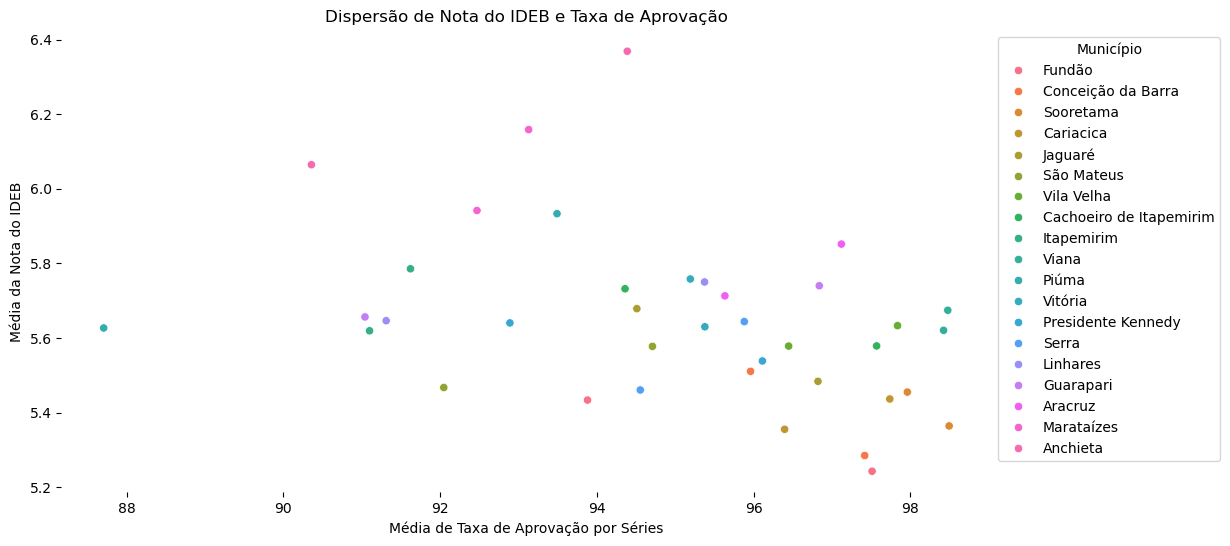

In [11]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Educ Base', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('IDEB: ', df.columns)


print('Nota SAEB e Taxa de Aprovação nas Escolas por Ano e Município')
df_tline = df.group_by(['id_municipio_nome', 'ano']) \
          .agg([pl.mean("nota_saeb_media_padronizada").alias("nota_saeb"), pl.mean("taxa_aprovacao").alias("taxa_aprovacao")]) \
          .sort(['ano', 'nota_saeb', ], descending=False).to_pandas() 


display(df_tline)
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário
ax = sns.scatterplot(data=df_tline, y=df_tline['nota_saeb'], x=df_tline['taxa_aprovacao'], hue=df_tline['id_municipio_nome'])
plt.ylabel('Média da Nota do IDEB')
plt.xlabel('Média de Taxa de Aprovação por Séries')
plt.title('Dispersão de Nota do IDEB e Taxa de Aprovação')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Município')
sns.despine(left=True, bottom=True)

### Enem

ENEM:  ['ano', 'id_inscricao', 'faixa_etaria', 'sexo', 'id_municipio_residencia', 'id_municipio_residencia_nome', 'sigla_uf_residencia', 'sigla_uf_residencia_nome', 'cor_raca', 'situacao_conclusao', 'ano_conclusao', 'tipo_escola', 'ensino', 'indicador_treineiro', 'id_municipio_escola', 'id_municipio_escola_nome', 'sigla_uf_escola', 'sigla_uf_escola_nome', 'dependencia_administrativa_escola', 'localizacao_escola', 'situacao_funcionamento_escola', 'indicador_certificado', 'nome_certificadora', 'sigla_uf_certificadora', 'sigla_uf_certificadora_nome', 'id_municipio_prova', 'id_municipio_prova_nome', 'sigla_uf_prova', 'sigla_uf_prova_nome', 'presenca_objetiva', 'tipo_prova_objetiva', 'nota_objetiva_competencia_1', 'nota_objetiva_competencia_2', 'nota_objetiva_competencia_3', 'nota_objetiva_competencia_4', 'nota_objetiva_competencia_5', 'nota_objetiva', 'presenca_ciencias_natureza', 'presenca_ciencias_humanas', 'presenca_linguagens_codigos', 'presenca_matematica', 'nota_ciencias_natureza', '

,ano,cor_raca,Nota Matemática,Nota Linguagens,Nota Ciências Humanas,Nota Ciências Naturais,Nota Redação
0,2021,Amarela,522.848485,488.996887,506.472763,494.518182,585.680934
1,2021,Branca,590.917150,533.476366,552.853195,528.654706,692.255581
2,2021,Indígena,494.037288,467.502564,465.815385,459.366102,532.307692
3,2021,Não declarado,564.070968,519.205660,537.074214,510.955484,642.138365
4,2021,Parda,538.238071,500.178655,513.649414,490.129040,615.605797
5,2021,Preta,519.976827,491.716351,504.360179,475.676594,594.060823
6,2022,Amarela,527.201365,499.896865,512.752978,490.457679,573.166144
7,2022,Branca,601.261129,547.377378,560.816265,527.157430,706.920559
8,2022,Indígena,518.978723,492.192000,515.218000,463.208511,586.800000
9,2022,Não declarado,564.601880,538.229682,542.867845,515.003008,654.558304


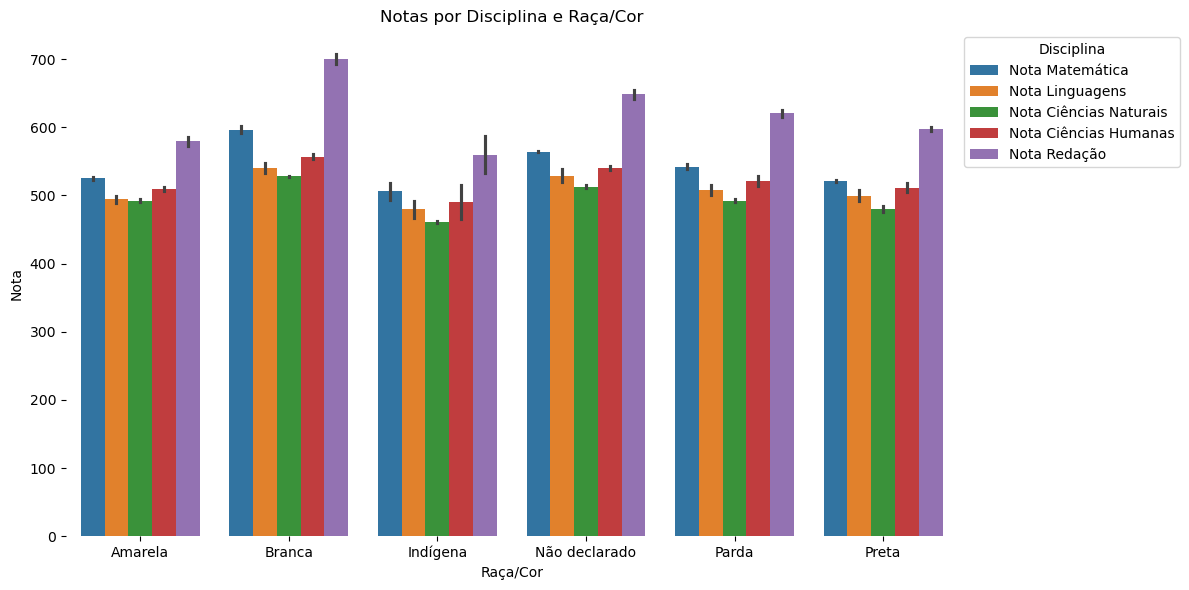

In [12]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Enem', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('ENEM: ', df.columns)

print('Notas por Raça/Cor e Ano')
df_tline = df.group_by(['ano', 'cor_raca',]) \
          .agg([pl.mean("nota_matematica").alias("Nota Matemática"), 
                pl.mean("nota_linguagens_codigos").alias("Nota Linguagens"), 
                pl.mean("nota_ciencias_humanas").alias("Nota Ciências Humanas"), 
                pl.mean("nota_ciencias_natureza").alias("Nota Ciências Naturais"), 
                pl.mean(['nota_redacao']).alias("Nota Redação"), 
                ])\
          .sort(['ano', 'cor_raca', 'Nota Matemática', ], descending=False).to_pandas() 

display(df_tline)
# Exemplo de como derreter o DataFrame para visualização
df_melted = df_tline.melt(id_vars=['cor_raca'], 
                          value_vars=['Nota Matemática', 'Nota Linguagens', 
                                      'Nota Ciências Naturais', 'Nota Ciências Humanas',  'Nota Redação'],
                          var_name='disciplina', value_name='nota')


# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_melted, x='cor_raca', y='nota', hue='disciplina')
ax.set_title("Notas por Disciplina e Raça/Cor")
ax.set_xlabel("Raça/Cor")
ax.set_ylabel("Nota")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Disciplina')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




### Censo do Ensino Superior

In [13]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Cursos Superiores', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Censo do Ensino Superio: ', df.columns)

print('Número de Cursos em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_nome']) \
          .agg([pl.count("id_curso").alias("Quantidade Cursos"), 
                ])\
          .sort(['ano', 'Quantidade Cursos', 'id_ies_nome', ], descending=True).to_pandas() 
display(df_tline)

print('Número de IES em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_tipo_instituicao']) \
          .agg([pl.count("id_ies").alias("Quantidade IES"), 
                ])\
          .sort(['ano', 'Quantidade IES', 'id_ies_tipo_instituicao', ], descending=True).to_pandas() 

display(df_tline)

print('Quantidade de Vagas em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_tipo_instituicao']) \
          .agg([pl.sum("quantidade_vagas").alias("Quantidade Vagas"), 
                ])\
          .sort(['ano', 'Quantidade Vagas', 'id_ies_tipo_instituicao', ], descending=True).to_pandas() 

display(df_tline)

print('Quantidade de Inscritos em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_ies_tipo_instituicao']) \
          .agg([pl.sum("quantidade_inscritos").alias("Quantidade Inscritos"), 
                ])\
          .sort(['ano', 'Quantidade Inscritos', 'id_ies_tipo_instituicao', ], descending=True).to_pandas() 

display(df_tline)


Censo do Ensino Superio:  ['ano', 'sigla_uf', 'id_municipio', 'id_municipio_nome', 'tipo_dimensao', 'tipo_organizacao_academica', 'tipo_organizacao_administrativa', 'rede', 'id_ies', 'id_ies_nome', 'id_ies_tipo_instituicao', 'id_curso', 'id_curso_nome_curso', 'id_curso_nome_area', 'id_curso_grau_academico', 'nome_curso_cine', 'id_curso_cine', 'id_area_geral', 'nome_area_geral', 'id_area_especifica', 'nome_area_especifica', 'id_area_detalhada', 'nome_area_detalhada', 'tipo_grau_academico', 'indicador_gratuito', 'tipo_modalidade_ensino', 'tipo_nivel_academico', 'quantidade_vagas', 'quantidade_vagas_diurno', 'quantidade_vagas_noturno', 'quantidade_vagas_ead', 'quantidade_vagas_novas', 'quantidade_vagas_processos_seletivos', 'quantidade_vagas_remanescentes', 'quantidade_vagas_programas_especiais', 'quantidade_inscritos', 'quantidade_inscritos_diurno', 'quantidade_inscritos_noturno', 'quantidade_inscritos_ead', 'quantidade_inscritos_vagas_novas', 'quantidade_inscritos_processos_seletivos', 

,ano,id_ies_nome,Quantidade Cursos
0,2022,Centro Universitário Leonardo Da Vinci,904
1,2022,Universidade Pitágoras Unopar Anhanguera,821
2,2022,Centro Universitário Internacional,695
3,2022,Universidade Cesumar,672
4,2022,Universidade Estácio De Sá,660
...,...,...,...
133,2022,Faculdade Brasileira De Cachoeiro,1
134,2022,Escola De Direito Fucape,1
135,2022,Centro Universitário Unibta,1
136,2022,Centro Universitário Planalto Do Distrito Federal - Uniplan,1


Número de IES em 2022


,ano,id_ies_tipo_instituicao,Quantidade IES
0,2022,Privada,8831
1,2022,Público,148


Quantidade de Vagas em 2022


,ano,id_ies_tipo_instituicao,Quantidade Vagas
0,2022,Privada,69649
1,2022,Público,7797


Quantidade de Inscritos em 2022


,ano,id_ies_tipo_instituicao,Quantidade Inscritos
0,2022,Privada,75668
1,2022,Público,61981


### IES

In [14]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Ies', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Instituições de Ensino Superior: ', df.columns)


print('Número de Docentes em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes").alias("Quantidade Docentes"), 
                ])\
          .sort(['ano', 'Quantidade Docentes', ], descending=True).to_pandas() 
display(df_tline)

print('Número de Docentes Doutores em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes_exercicio_doutorado").alias("Quantidade Doutores"), 
                ])\
          .sort(['ano', 'Quantidade Doutores', ], descending=True).to_pandas() 

display(df_tline)

print('Número de Docentes Mestres em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes_exercicio_mestrado").alias("Quantidade Mestres"), 
                ])\
          .sort(['ano', 'Quantidade Mestres', ], descending=True).to_pandas() 

display(df_tline)

print('Número de Docentes Especialistas em 2022')
df_tline = df.filter(pl.col('ano')>= 2022)\
          .group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("quantidade_docentes_exercicio_especializacao").alias("Quantidade Especialistas"), 
                ])\
          .sort(['ano', 'Quantidade Especialistas', ], descending=True).to_pandas() 

display(df_tline)

Instituições de Ensino Superior:  ['ano', 'sigla_uf', 'id_municipio', 'id_municipio_nome', 'tipo_organizacao_academica', 'tipo_categoria_administrativa', 'nome_mantenedora', 'id_mantenedora', 'id_ies', 'id_ies_nome', 'id_ies_tipo_instituicao', 'nome', 'sigla', 'endereco', 'numero', 'complemento', 'bairro', 'cep', 'cep_logradouro', 'cep_localidade', 'quantidade_tecnicos', 'quantidade_tecnicos_ef_incompleto_feminino', 'quantidade_tecnicos_ef_incompleto_masculino', 'quantidade_tecnicos_ef_completo_feminino', 'quantidade_tecnicos_ef_completo_masculino', 'quantidade_tecnicos_em_feminino', 'quantidade_tecnicos_em_masculino', 'quantidade_tecnicos_es_feminino', 'quantidade_tecnicos_es_masculino', 'quantidade_tecnicos_especializacao_feminino', 'quantidade_tecnicos_especializacao_masculino', 'quantidade_tecnicos_mestrado_feminino', 'quantidade_tecnicos_mestrado_masculino', 'quantidade_tecnicos_doutorado_feminino', 'quantidade_tecnicos_doutorado_masculino', 'indicador_biblioteca_acesso_portal_cap

,ano,id_municipio_nome,Quantidade Docentes
0,2022,Vitória,4214
1,2022,Vila Velha,582
2,2022,Serra,453
3,2022,Cachoeiro de Itapemirim,329
4,2022,Guarapari,243
5,2022,São Mateus,151
6,2022,Linhares,148
7,2022,Cariacica,115
8,2022,Aracruz,56


Número de Docentes Doutores em 2022


,ano,id_municipio_nome,Quantidade Doutores
0,2022,Vitória,2502
1,2022,Vila Velha,177
2,2022,Guarapari,145
3,2022,Serra,107
4,2022,Linhares,48
5,2022,Cachoeiro de Itapemirim,48
6,2022,São Mateus,39
7,2022,Cariacica,17
8,2022,Aracruz,8


Número de Docentes Mestres em 2022


,ano,id_municipio_nome,Quantidade Mestres
0,2022,Vitória,1232
1,2022,Vila Velha,297
2,2022,Serra,248
3,2022,Cachoeiro de Itapemirim,118
4,2022,Guarapari,64
5,2022,São Mateus,63
6,2022,Cariacica,61
7,2022,Linhares,55
8,2022,Aracruz,36


Número de Docentes Especialistas em 2022


,ano,id_municipio_nome,Quantidade Especialistas
0,2022,Vitória,327
1,2022,Cachoeiro de Itapemirim,161
2,2022,Serra,95
3,2022,Vila Velha,77
4,2022,Linhares,45
5,2022,São Mateus,44
6,2022,Guarapari,34
7,2022,Cariacica,30
8,2022,Aracruz,10


## Dados Econômicos Municipais

### PIB

PIB Municipal:  ['id_municipio', 'id_municipio_nome', 'ano', 'pib', 'impostos_liquidos', 'va', 'va_agropecuaria', 'va_industria', 'va_servicos', 'va_adespss']


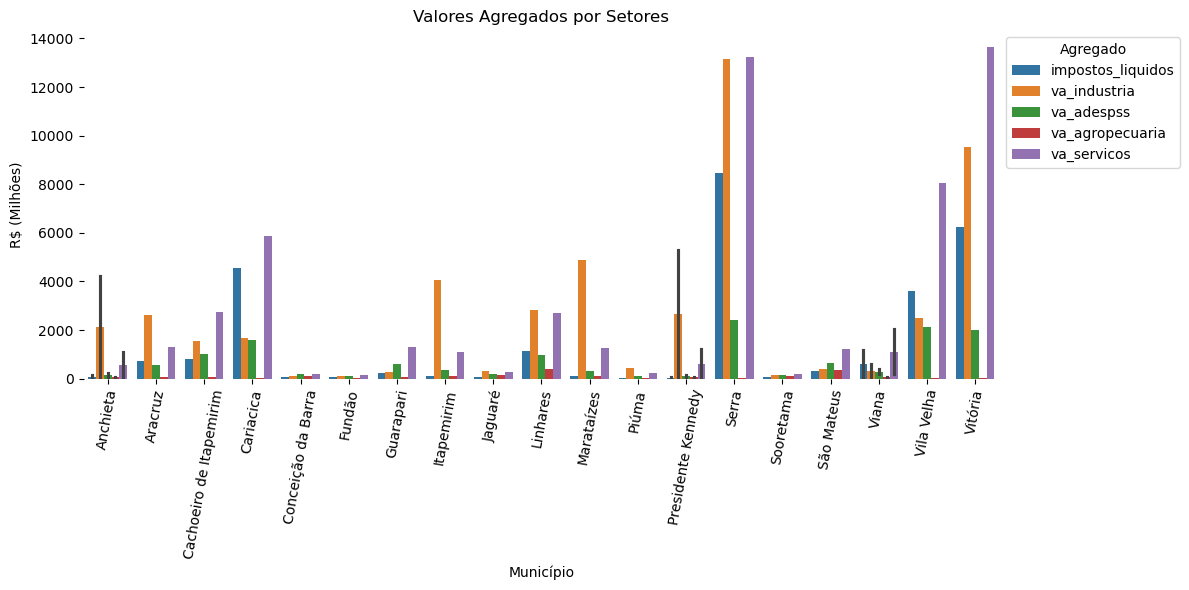

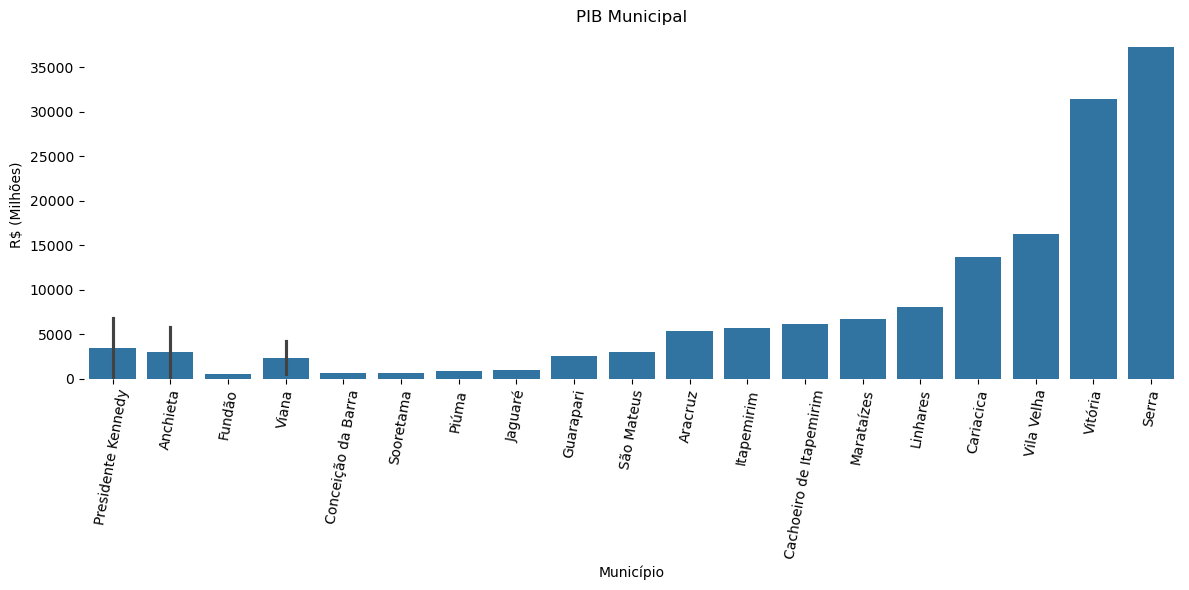

In [15]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Pib Municipios', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('PIB Municipal: ', df.columns)


df = df.to_pandas().sort_values('pib')


# Exemplo de como derreter o DataFrame para visualização
df_melted = df.melt(id_vars=['id_municipio_nome'], 
                          value_vars=['impostos_liquidos', 'va_adespss',
                                      'va_agropecuaria', 'va_industria',  'va_servicos'],
                          var_name='VA', value_name='$').sort_values(['id_municipio_nome','$'])



df_melted['$'] = df_melted['$'] / 1000000
df['pib'] = df['pib'] / 1000000

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_melted, x='id_municipio_nome', y='$', hue='VA')
ax.set_title("Valores Agregados por Setores")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Agregado')
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()



# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df, x='id_municipio_nome', y='pib')
ax.set_title("PIB Municipal")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




### Transferêcias FUNDEB

id_municipio_nome,uf,mes,ano,transferencias
null,null,i32,null,f64


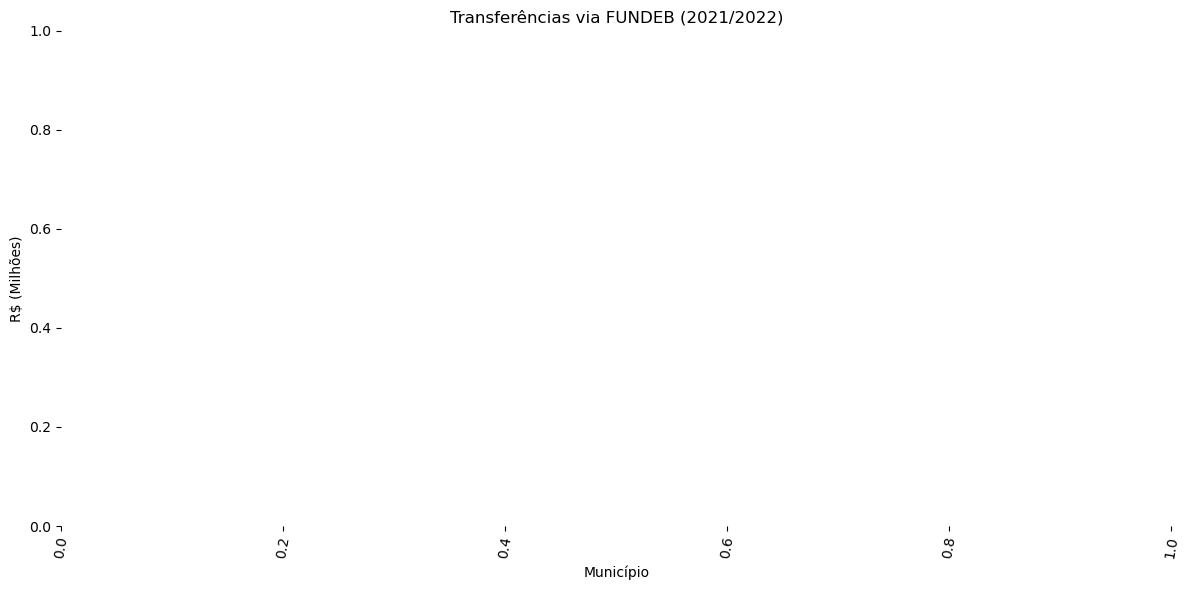

In [30]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Transferencias Fundeb', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])




display(df)

df_tline = df.group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("transferencias").alias("Transferências Fundeb"), 
                ])\
          .sort(['Transferências Fundeb', ], descending=False).to_pandas() 



df_tline['Transferências Fundeb'] = df_tline['Transferências Fundeb'] / 1000000

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_tline, x='id_municipio_nome', y='Transferências Fundeb')
ax.set_title("Transferências via FUNDEB (2021/2022)")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


### Transferências Fundo de Participação dos Municípios

id_municipio_nome,uf,mes,ano,transferencias
null,null,i32,null,f64


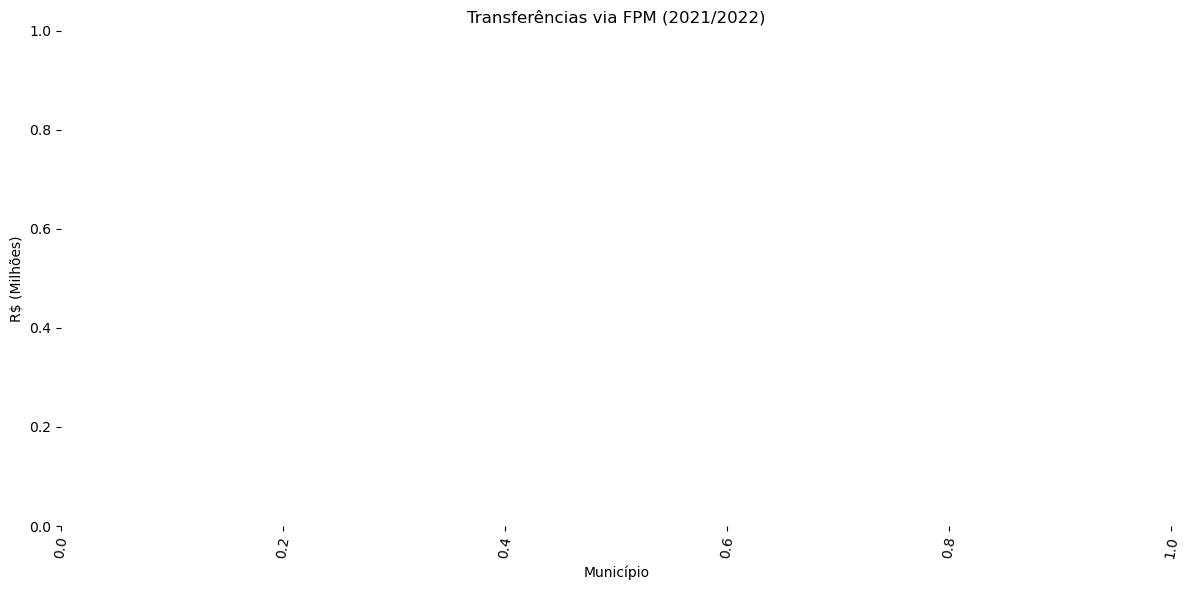

In [31]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Transferencias Fpm', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])




display(df)

df_tline = df.group_by(['ano', 'id_municipio_nome']) \
          .agg([pl.sum("transferencias").alias("Transferências FPM"), 
                ])\
          .sort(['Transferências FPM', ], descending=False).to_pandas() 



df_tline['Transferências FPM'] = df_tline['Transferências FPM'] / 1000000

# Aumentar o tamanho da figura
plt.figure(figsize=(12, 6))  # Aumente os valores para dar mais espaço, se necessário

# Gerar o gráfico com as barras lado a lado para cada raça
ax = sns.barplot(data=df_tline, x='id_municipio_nome', y='Transferências FPM')
ax.set_title("Transferências via FPM (2021/2022)")
ax.set_xlabel("Município")
ax.set_ylabel("R$ (Milhões)")
plt.xticks(rotation=80)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [16]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Agua', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Abastecimento de Água: ')

display(df)



df.write_excel('Censo Agua.xlsx')

Abastecimento de Água: 


ano,id_municipio,id_municipio_nome,tipo_ligacao_rede_geral,domicilios
i64,str,str,str,i64
2022,"""4200804""","""Anchieta""","""Não possui ligação com a rede geral - Outra""",null
2022,"""3204203""","""Piúma""","""Não possui ligação com a rede geral - Carro-pipa""",null
2022,"""3202405""","""Guarapari""","""Não possui ligação com a rede geral - Carro-pipa""",null
2022,"""3202207""","""Fundão""","""Não possui ligação com a rede geral - Carro-pipa""",null
2022,"""3202801""","""Itapemirim""","""Não possui ligação com a rede geral - Carro-pipa""",null
…,…,…,…,…
2022,"""2112803""","""Viana""","""Possui ligação à rede geral e a utiliza como forma principal""",4599
2022,"""3200409""","""Anchieta""","""Possui ligação à rede geral e a utiliza como forma principal""",9207
2022,"""3202207""","""Fundão""","""Possui ligação à rede geral e a utiliza como forma principal""",5625


In [17]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Censo Esgoto', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Saneamento: ')

display(df)

df.write_excel('Censo Esgoto.xlsx')

Saneamento: 


ano,id_municipio,id_municipio_nome,tipo_esgotamento_sanitario,domicilios
i64,str,str,str,i64
2022,"""4200804""","""Anchieta""","""Vala""",3
2022,"""1718402""","""Presidente Kennedy""","""Vala""",3
2022,"""3204906""","""São Mateus""","""Vala""",774
2022,"""3201308""","""Cariacica""","""Vala""",5907
2022,"""3203056""","""Jaguaré""","""Vala""",22
…,…,…,…,…
2022,"""3200607""","""Aracruz""","""Fossa séptica ou fossa filtro não ligada à rede""",2238
2022,"""3204302""","""Presidente Kennedy""","""Fossa séptica ou fossa filtro não ligada à rede""",454
2022,"""3201605""","""Conceição da Barra""","""Fossa séptica ou fossa filtro não ligada à rede""",3270


In [18]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Densidade Internet', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Acesso à Internet: ')

display(df)

df.write_excel('Densidade Internet.xlsx')

Acesso à Internet: 


sigla_uf,sigla_uf_nome,ano,mes,id_municipio,id_municipio_nome,densidade
str,str,i64,i64,str,str,f64
"""ES""","""Espírito Santo""",2021,1,"""3200409""","""Anchieta""",12.354344
"""ES""","""Espírito Santo""",2021,2,"""3200409""","""Anchieta""",13.314752
"""ES""","""Espírito Santo""",2021,3,"""3200409""","""Anchieta""",12.246885
"""ES""","""Espírito Santo""",2021,4,"""3200409""","""Anchieta""",12.102488
"""ES""","""Espírito Santo""",2021,5,"""3200409""","""Anchieta""",14.231505
…,…,…,…,…,…,…
"""ES""","""Espírito Santo""",2024,2,"""3205101""","""Viana""",14.890429
"""ES""","""Espírito Santo""",2024,1,"""3205200""","""Vila Velha""",31.441326
"""ES""","""Espírito Santo""",2024,2,"""3205200""","""Vila Velha""",31.627334


In [25]:
df = pl.DataFrame()
files_list = glob(os.path.join(proj_dir, 'Dados', 'Banda Larga', fr'*.parquet'))

for file in files_list:
    df_iter = pl.read_parquet(file)
    df = pl.concat([df, df_iter])
print('Fornecedores de acesso à internet: ')

display(df)

df_grouped = (pl.DataFrame(df).group_by(["velocidade", "id_municipio", "id_municipio_nome", "ano", "mes"])
      .agg([pl.col("acessos").sum()]))

display(df_grouped)

df_grouped.write_excel('Banda Larga Heatmap.xlsx')



Fornecedores de acesso à internet: 


mes,ano,porte_empresa,transmissao,id_municipio,id_municipio_nome,acessos,velocidade,empresa,cnpj,produto,tecnologia,sigla_uf,sigla_uf_nome
i64,i64,str,str,str,str,i64,str,str,str,str,str,str,str
3,2021,"""Grande Porte""","""Cabo Metalico""","""3205309""","""Vitória""",2,"""512kbps a 2Mbps""","""OI""","""33000118000179""","""linha dedicada""","""FR""","""ES""","""Espírito Santo"""
5,2021,"""Grande Porte""","""Cabo Metalico""","""3205309""","""Vitória""",2,"""0Kbps a 512Kbps""","""OI""","""33000118000179""","""linha dedicada""","""FR""","""ES""","""Espírito Santo"""
1,2021,"""Grande Porte""","""Cabo Metalico""","""3205002""","""Serra""",1,"""0Kbps a 512Kbps""","""OI""","""33000118000179""","""linha dedicada""","""FR""","""ES""","""Espírito Santo"""
1,2021,"""Grande Porte""","""Cabo Metalico""","""3201209""","""Cachoeiro de Itapemirim""",1,"""0Kbps a 512Kbps""","""OI""","""33000118000179""","""linha dedicada""","""FR""","""ES""","""Espírito Santo"""
5,2021,"""Grande Porte""","""Cabo Metalico""","""3204906""","""São Mateus""",1,"""0Kbps a 512Kbps""","""OI""","""33000118000179""","""linha dedicada""","""FR""","""ES""","""Espírito Santo"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,2024,"""Pequeno Porte""","""Radio""","""3201209""","""Cachoeiro de Itapemirim""",32,"""2Mbps a 12Mbps""","""MAURO GAVA - ME""","""18679602000182""","""internet""","""ETHERNET""","""ES""","""Espírito Santo"""
2,2024,"""Pequeno Porte""","""Radio""","""3201209""","""Cachoeiro de Itapemirim""",197,"""2Mbps a 12Mbps""","""MAURO GAVA - ME""","""18679602000182""","""internet""","""ETHERNET""","""ES""","""Espírito Santo"""
1,2024,"""Grande Porte""","""Cabo Metalico""","""3201209""","""Cachoeiro de Itapemirim""",4,"""> 34Mbps""","""OI""","""76535764000143""","""linha dedicada""","""ETHERNET""","""ES""","""Espírito Santo"""


velocidade,id_municipio,id_municipio_nome,ano,mes,acessos
str,str,str,i64,i64,i64
"""2Mbps a 12Mbps""","""3205309""","""Vitória""",2021,6,9863
"""2Mbps a 12Mbps""","""3205309""","""Vitória""",2022,11,6383
"""512kbps a 2Mbps""","""3205010""","""Sooretama""",2024,2,35
"""12Mbps a 34Mbps""","""3200607""","""Aracruz""",2022,3,2383
"""> 34Mbps""","""3204203""","""Piúma""",2023,2,5528
…,…,…,…,…,…
"""12Mbps a 34Mbps""","""3200607""","""Aracruz""",2024,2,1414
"""0Kbps a 512Kbps""","""3204906""","""São Mateus""",2021,1,52
"""512kbps a 2Mbps""","""3203205""","""Linhares""",2022,1,344
